In [15]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [16]:
import cv2
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load data

In [17]:
SEED = 42
np.random.seed(SEED)

# Path
UNZIP_PATH = '../input/data-science-bowl-2018/'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

# Image parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [18]:
with zipfile.ZipFile(UNZIP_PATH + 'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
with zipfile.ZipFile(UNZIP_PATH + 'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [19]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [20]:
def load_data():
    train_ids = next(os.walk(TRAIN_PATH))[1]
    X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
    y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]

        # Apply CLAHE to the image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
        l, a, b = cv2.split(img)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img = cv2.merge((l, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)  # Convert back to RGB

        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        y[n] = mask

    return X, y

In [21]:
X, y = load_data()

In [22]:
X.shape

(670, 128, 128, 3)

In [23]:
y.shape

(670, 128, 128, 1)

# Plot the first five images from X

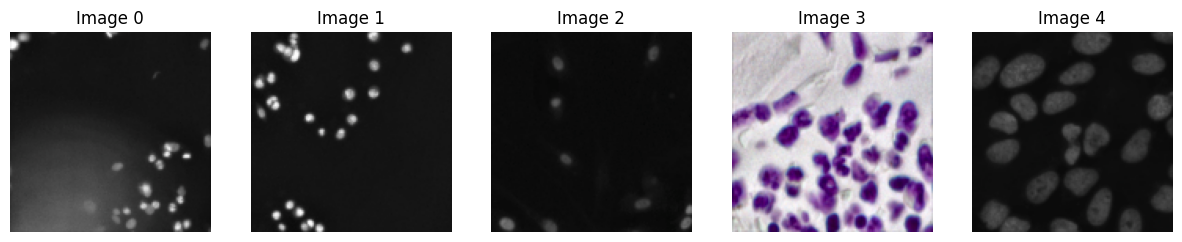

In [24]:
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f'Image {i}')
plt.show()

# Plot the first five masks from y

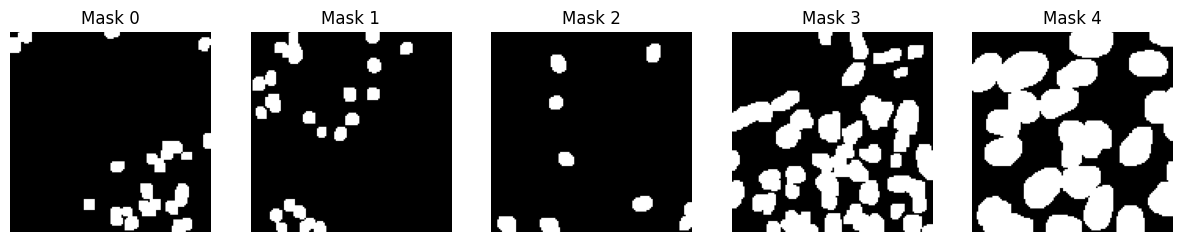

In [25]:
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.squeeze(y[i]), cmap='gray')
    plt.axis('off')
    plt.title(f'Mask {i}')
plt.show()

# Plot the last five images from X

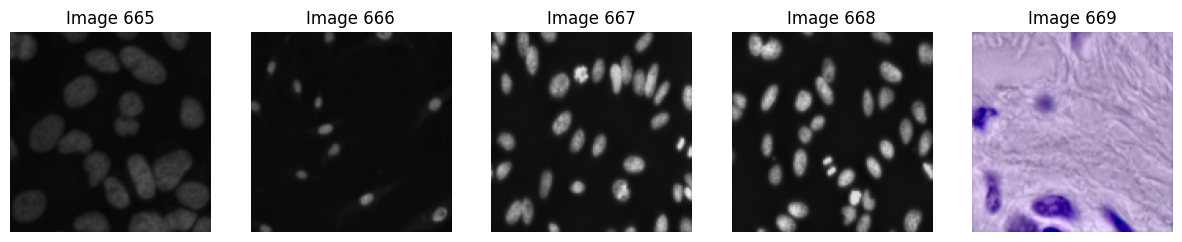

In [26]:
plt.figure(figsize=(15, 5))
for i in range(-5, 0):
    plt.subplot(1, 5, i+6)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f'Image {len(X) + i}')
plt.show()

# Plot the last five masks from y

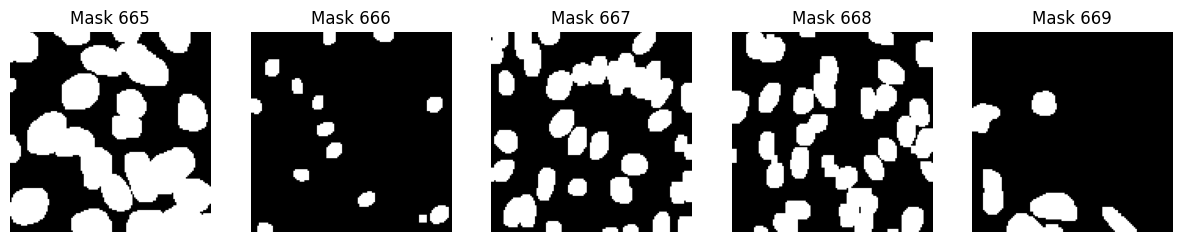

In [27]:
plt.figure(figsize=(15, 5))
for i in range(-5, 0):
    plt.subplot(1, 5, i+6)
    plt.imshow(np.squeeze(y[i]), cmap='gray')
    plt.axis('off')
    plt.title(f'Mask {len(y) + i}')
plt.show()

# Unet

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.initializers import glorot_uniform

def unet_model(input_size=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)):
    inputs = Input(input_size)

    # Contraction Path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansion Path
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    concat6 = concatenate([up6, drop4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(concat6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(concat7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(concat8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(concat9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# Define StratifiedKFold

In [29]:
# Flatten the image data
X_flat = X.reshape(-1, X.shape[-1])
# Flatten the mask data
y_flat = y.reshape(-1, y.shape[-1])
# Check the new shapes
print("Flattened X shape:", X_flat.shape)
print("Flattened y shape:", y_flat.shape)

Flattened X shape: (10977280, 3)
Flattened y shape: (10977280, 1)


In [30]:
# Check unique values in y_flat
unique_values = np.unique(y_flat)
print("Unique values in y_flat:", unique_values)
# If there are values other than 0 and 1, you might need to threshold the mask
y_flat_thresholded = np.where(y_flat > 0, 1, 0)
# Check the unique values after thresholding
unique_values_thresholded = np.unique(y_flat_thresholded)
print("Unique values in y_flat_thresholded:", unique_values_thresholded)

Unique values in y_flat: [False  True]
Unique values in y_flat_thresholded: [0 1]


In [31]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
val_loss_list = []
val_accuracy_list = []
val_mean_iou_list = []
# Loop through the folds
for i, (train_index, test_index) in enumerate(skf.split(X_flat, y_flat_thresholded), 1):
    print(f"\n\n----------Mulai Fold {i}:----------\n")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")
    print("----------------------")
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y_flat_thresholded[train_index], y_flat_thresholded[test_index]
    # Reshape input data to match the model's input shape
    X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    y_train = y_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
    y_test = y_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
    model = unet_model(input_size=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
    # Inisialisasi fungsi loss
    bce_loss = BinaryCrossentropy()
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=bce_loss, metrics=['accuracy', MeanIoU(num_classes=2, name='mean_iou')])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, 
                                     restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                    patience=5, min_lr=0.00001)
    # Fit the model
    history = model.fit(
                X_train,
                y_train,
                validation_data=(X_test, y_test),
                batch_size=32,
                epochs=50,
                callbacks=[early_stopping,reduce_lr]
                )
    # Evaluate the model
    eval_results = model.evaluate(X_test, y_test)
    val_loss, val_accuracy, val_mean_iou = eval_results[0], eval_results[1], eval_results[2]
    print(f"\nloss : {val_loss}")
    print(f"accuracy : {val_accuracy}")
    print(f"mean iou : {val_mean_iou}")
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    val_mean_iou_list.append(val_mean_iou)
    print(f"\n----------Akhir dari fold {i}----------\n\n")



----------Mulai Fold 1:----------

Train indices: [       0        1        2 ... 10977277 10977278 10977279]
Test indices: [       8       16       23 ... 10977262 10977266 10977268]
----------------------
Epoch 1/50
17/17 [==============================] - 29s 617ms/step - loss: 0.5943 - accuracy: 0.7339 - mean_iou: 0.3766 - val_loss: 1.6900 - val_accuracy: 0.5175 - val_mean_iou: 0.4003 - lr: 1.0000e-04
Epoch 2/50
17/17 [==============================] - 5s 280ms/step - loss: 0.4356 - accuracy: 0.8454 - mean_iou: 0.3793 - val_loss: 1.2656 - val_accuracy: 0.6205 - val_mean_iou: 0.4039 - lr: 1.0000e-04
Epoch 3/50
17/17 [==============================] - 5s 272ms/step - loss: 0.3943 - accuracy: 0.8695 - mean_iou: 0.3819 - val_loss: 1.6480 - val_accuracy: 0.6172 - val_mean_iou: 0.4288 - lr: 1.0000e-04
Epoch 4/50
17/17 [==============================] - 5s 280ms/step - loss: 0.3724 - accuracy: 0.8834 - mean_iou: 0.3813 - val_loss: 1.2098 - val_accuracy: 0.7255 - val_mean_iou: 0.4310 - l

In [32]:
for i, (loss, accuracy, iou) in enumerate(zip(val_loss_list, val_accuracy_list, val_mean_iou_list), 1):
    print(f"Fold {i}: \n Loss={loss}\n Accuracy={accuracy}\n Mean IoU={iou}\n")

Fold 1: 
 Loss=1.013771891593933
 Accuracy=0.7700363993644714
 Mean IoU=0.38755717873573303

Fold 2: 
 Loss=1.4709852933883667
 Accuracy=0.5985280275344849
 Mean IoU=0.4257345199584961

Fold 3: 
 Loss=1.2735916376113892
 Accuracy=0.7616477012634277
 Mean IoU=0.4233391284942627

Fold 4: 
 Loss=1.1328063011169434
 Accuracy=0.649703323841095
 Mean IoU=0.4010019898414612

Fold 5: 
 Loss=0.973730742931366
 Accuracy=0.7713695764541626
 Mean IoU=0.4120272696018219



In [33]:
# Calculate average metrics
avg_val_loss = np.mean(val_loss_list)
avg_val_accuracy = np.mean(val_accuracy_list)
avg_val_mean_iou = np.mean(val_mean_iou_list)

print("Average Validation Loss:", avg_val_loss)
print("Average Validation Accuracy:", avg_val_accuracy)
print("Average Validation Mean IoU:", avg_val_mean_iou)

Average Validation Loss: 1.1729771733283996
Average Validation Accuracy: 0.7102570056915283
Average Validation Mean IoU: 0.409932017326355


In [34]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)
# Convert predictions to binary format
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

5/5 [==============================] - 0s 59ms/step


In [35]:
# Calculate IoU, Dice Coefficient, and Pixel Accuracy on training set
train_iou = MeanIoU(num_classes=2)
train_iou.update_state(y_train, preds_train_t)
train_dice = 2 * train_iou.result().numpy() / (train_iou.result().numpy() + 1)
train_pixel_accuracy = accuracy_score(y_train.flatten(), preds_train_t.flatten())

print(f'Training IoU: {train_iou.result().numpy():.4f}')
print(f'Training Dice Coefficient: {train_dice:.4f}')
print(f'Training Pixel Accuracy: {train_pixel_accuracy*100:.2f}%')

Training IoU: 0.7076
Training Dice Coefficient: 0.8288
Training Pixel Accuracy: 86.62%


In [36]:
# Calculate IoU, Dice Coefficient, and Pixel Accuracy on validation set
val_iou = MeanIoU(num_classes=2)
val_iou.update_state(y_test, preds_val_t)
val_dice = 2 * val_iou.result().numpy() / (val_iou.result().numpy() + 1)
val_pixel_accuracy = accuracy_score(y_test.flatten(), preds_val_t.flatten())

print(f'Validation IoU: {val_iou.result().numpy():.4f}')
print(f'Validation Dice Coefficient: {val_dice:.4f}')
print(f'Validation Pixel Accuracy: {val_pixel_accuracy*100:.2f}')

Validation IoU: 0.5807
Validation Dice Coefficient: 0.7347
Validation Pixel Accuracy: 77.14


# Loss Curve

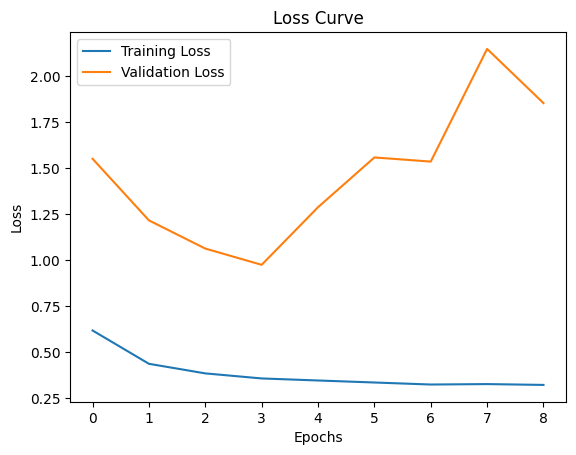

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Curve

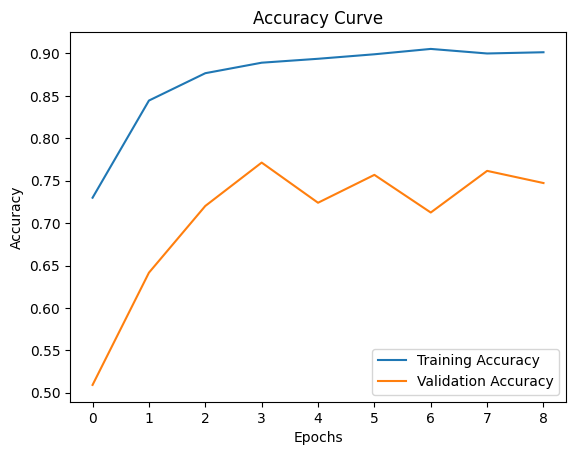

In [38]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# IoU Curve

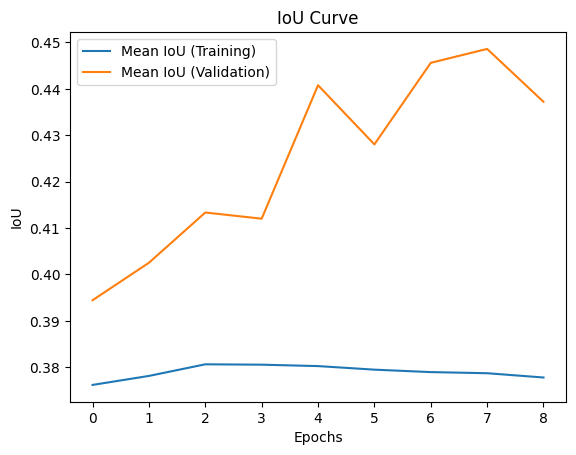

In [39]:
plt.plot(history.history['mean_iou'], label='Mean IoU (Training)')
plt.plot(history.history['val_mean_iou'], label='Mean IoU (Validation)')
plt.title('IoU Curve')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# Model Summary

In [40]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_72 (Ba  (None, 128, 128, 64)         256       ['conv2d_76[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_77 (Conv2D)          (None, 128, 128, 64)         36928     ['batch_normalization_72

# Model Architecture

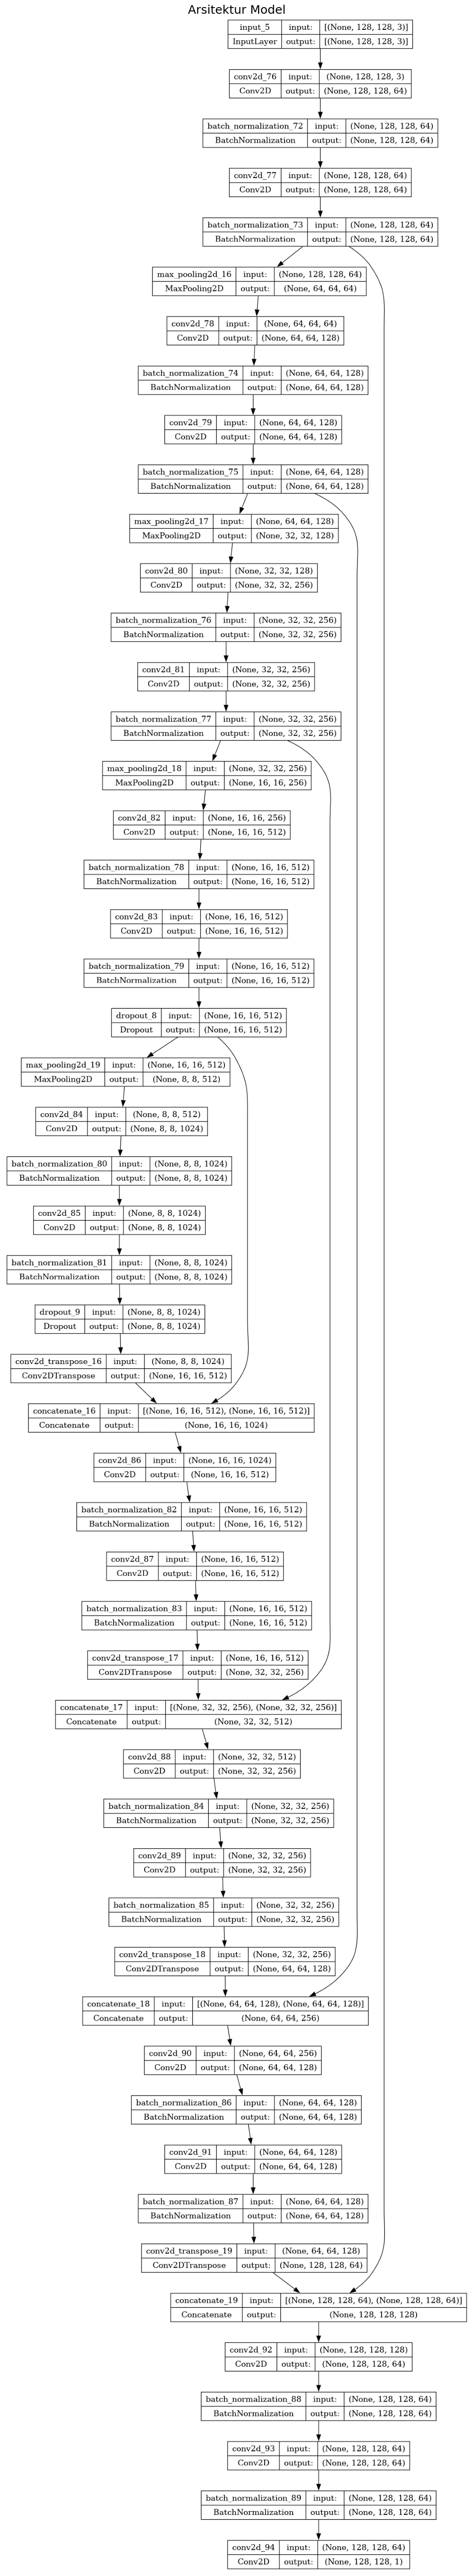

In [41]:
from keras.utils import plot_model
file_name = 'arsitektur_model.png'
plot_model(model, to_file=file_name, show_shapes=True, show_layer_names=True)
plt.figure(figsize=(70,70))
img = plt.imread(file_name)
plt.imshow(img)
plt.title('Arsitektur Model', fontsize=18) 
plt.axis('off') 
plt.savefig(file_name) 
plt.show()

# Confusion Matrix

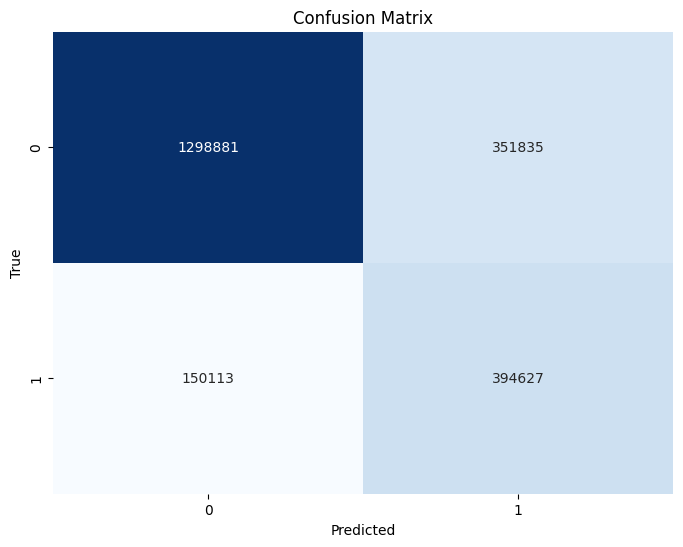

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predictions to binary format
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Flatten the true and predicted labels
y_true_flat = y_test.flatten()
y_pred_flat = preds_val_t.flatten()

# Create confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Function to display images
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

2/2 [==============================] - 2s 2s/step


# A random index from training set

Input Image:


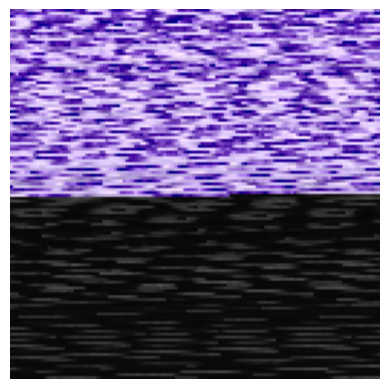

Ground Truth Mask:


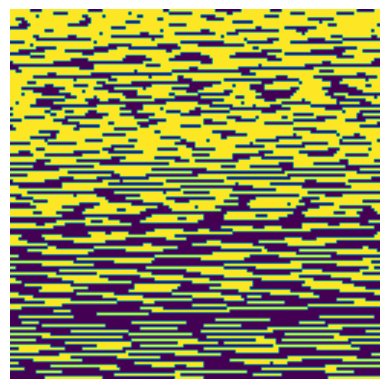

Predicted Mask:


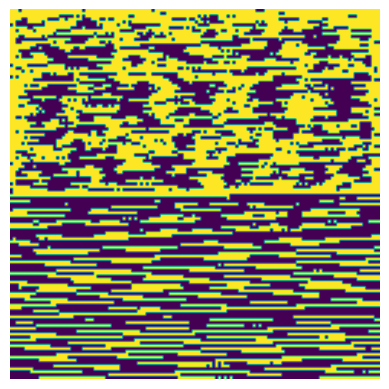

In [44]:
ix = random.randint(0, len(preds_train_t))
print("Input Image:")
display_images(X_train[ix])
print("Ground Truth Mask:")
display_images(np.squeeze(y_train[ix]))
print("Predicted Mask:")
display_images(np.squeeze(preds_train_t[ix]))

# A random index from validation set

Validation Input Image:


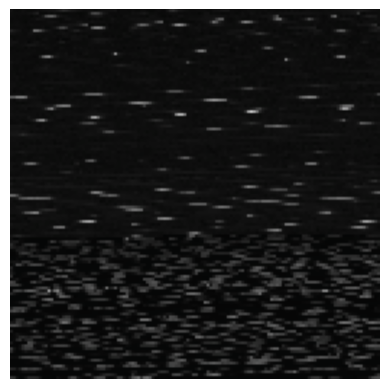

Validation Ground Truth Mask:


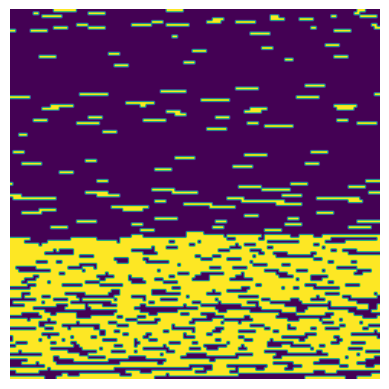

Validation Predicted Mask:


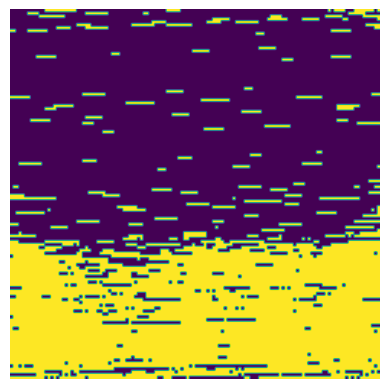

In [45]:
ix = random.randint(0, len(preds_val_t))
val_data_start = int(X_train.shape[0] * 0.9)
print("Validation Input Image:")
display_images(X_train[val_data_start:][ix])
print("Validation Ground Truth Mask:")
display_images(np.squeeze(y_train[val_data_start:][ix]))
print("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))

# X_test

In [46]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])

    # Apply CLAHE to the image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)  # Convert back to RGB

    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 42.12it/s]


In [47]:
X_test.shape

(65, 128, 128, 3)

# Plot the first five images from X_test

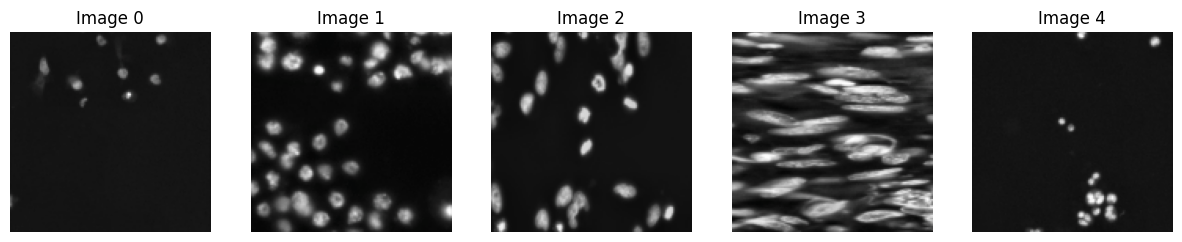

In [48]:
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Image {i}')
plt.show()

# Plot the last five images from X_test

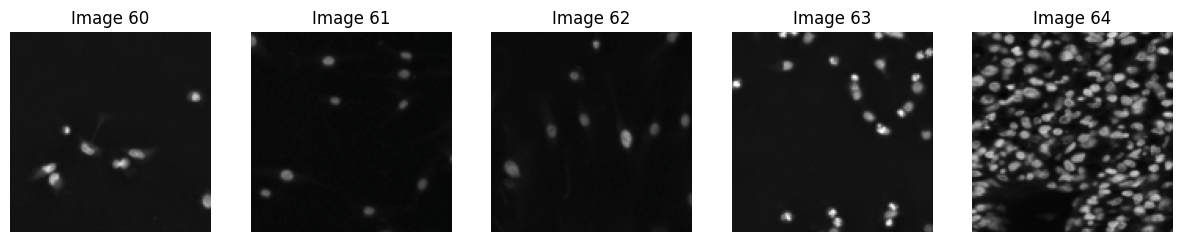

In [49]:
plt.figure(figsize=(15, 5))
for i in range(-5, 0):
    plt.subplot(1, 5, i+6)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Image {len(X_test) + i}')
plt.show()

In [50]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 222ms/step


# A random index from X_test

Test Image:


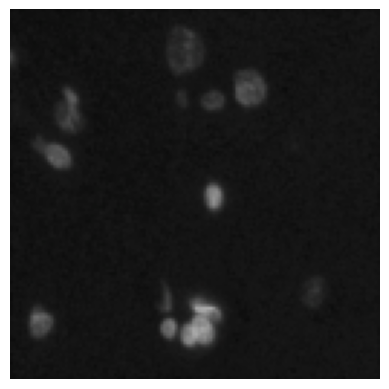

Predicted Mask:


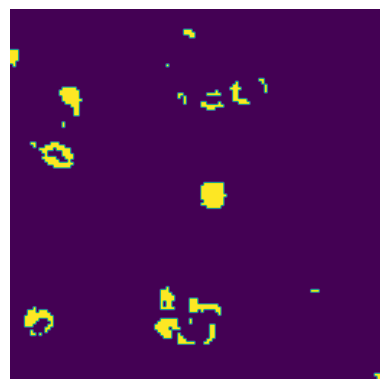

In [51]:
ix = random.randint(0, len(preds_test_t))
print("Test Image:")
display_images(X_test[ix])
print("Predicted Mask:")
display_images(np.squeeze(preds_test_t[ix]))

In [52]:
model.save("mymodel.h5")
model.save('my_model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
